# Alchemical PES and their errors


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.utils import _remove_dimer_outliers, _dimer_poly_pred, all_dimer_systems
from apdft_tools.data import prepare_dfs
from apdft_tools.prediction import *

json_path = '../../json-data/dimer-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

Specifies the system of interest.

In [2]:
basis_set = 'cc-pV5Z'
specific_atom = 0

n_points = 2
poly_order = 4

qm_color = '#577590'

## Lollipop chart


/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(


Bond Lengths
['b.h' 'c.h' 'n.h' 'o.h']
[[1.24883071 1.20004399 1.20158205 1.19939719]
 [1.08011695 1.11414259 1.08540528 1.08460026]
 [1.03240214 1.08597254 1.06658251 1.08935773]
 [1.9        1.9        1.9        1.9       ]]


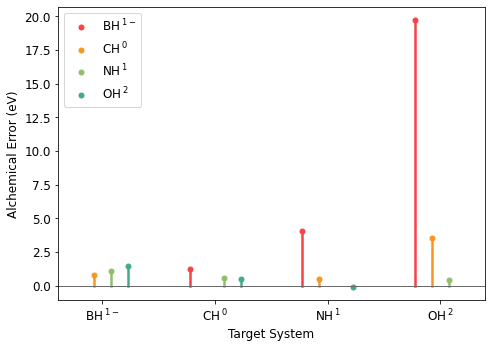

In [3]:
sys_selection_idx = 3  # 0 to 6
sys_charge = 0
excitation_level = 0
considered_lambdas = None

reference_data = 'qc'  # qc or alchemy (really APDFT)
use_fin_diff_pred = False  # Always False

# Gets number of electrons and APDFT systems.
sel_dimer_sys = [all_dimer_systems[sys_selection_idx]]
sel_dimer_charge = [sys_charge]
init_sys = df_qc.query(
    'system == @sel_dimer_sys'
    '& charge == 0'
    '& basis_set == @basis_set'
    '& bond_length == 1.0'
)
n_electrons = init_sys.iloc[0]['n_electrons']


df_refs_labels = get_apdft_refs(
    df_qc, df_apdft, sel_dimer_sys[0], n_electrons,
    basis_set=basis_set, df_selection=reference_data,
    excitation_level=excitation_level,
    specific_atom=0, direction=None
)
df_refs_labels = df_refs_labels.query('bond_length == 1.0')
sel_dimer_sys.extend(list(df_refs_labels['system'].values))
sel_dimer_sys = np.array(sel_dimer_sys)
sel_dimer_charge.extend(list(df_refs_labels['charge'].values))
sel_dimer_charge = np.array(sel_dimer_charge)

charge_sort = np.argsort(sel_dimer_charge)
sel_dimer_sys = sel_dimer_sys[charge_sort]
sel_dimer_charge = sel_dimer_charge[charge_sort]

system_labels_condensed = []
for i in range(len(sel_dimer_sys)):
    sys_label = ''.join([atom.capitalize() for atom in sel_dimer_sys[i].split('.')])
    charge = str(sel_dimer_charge[i])
    if charge[0] == '-':
        charge = charge[1] + '-'
    label = sys_label
    if charge != 0:
        label += '$\,^{' + charge + '}$'
    system_labels_condensed.append(label)

# Energy predictions
energy_errors = np.zeros((len(sel_dimer_sys), len(sel_dimer_sys)))
bond_lengths = np.zeros((len(sel_dimer_sys), len(sel_dimer_sys)))  # For curiosity

for i in range(len(sel_dimer_sys)):
    
    ref_system_label = sel_dimer_sys[i]
    ref_charge = sel_dimer_charge[i]
    
    bl_ref, e_ref = dimer_eq(
        df_qc, ref_system_label, ref_charge, excitation_level=excitation_level, calc_type=reference_data,
        use_fin_diff=False, df_apdft=df_apdft, specific_atom=0,
        direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
        remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
    )
    e_ref = hartree_to_ev(e_ref[ref_system_label][0])
    
    bl_predictions, e_predictions = dimer_eq(
        df_qc, ref_system_label, ref_charge, excitation_level=excitation_level, calc_type='alchemy',
        use_fin_diff=use_fin_diff_pred, df_apdft=df_apdft, specific_atom=0,
        direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
        remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
    )
    
    for j in range(len(sel_dimer_sys)):
        ref_label = sel_dimer_sys[j]
        if j != i:
            e_pred = hartree_to_ev(e_predictions[ref_label][0])
            energy_errors[i,j] = e_pred - e_ref
            
            bond_lengths[i,j] = bl_predictions[ref_label][0]
        else:
            bond_lengths[i,j] = bl_ref[ref_label][0]
        

            
###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')
sys_colors = [
    '#F94144', '#F8961E', '#90BE6D', '#43AA8B', '#577590'
]
marker_size = 5
line_width = 2.5
j_offset = 0.15

for i in range(len(system_labels_condensed)):
    energies = energy_errors[i,:]

    x = [i+j*j_offset for j in range(i+len(energies))]
    for j in range(len(system_labels_condensed)):
        if i == j and i != 0:
            color = 'white'
        else:
            color = sys_colors[j]
        
        ax.plot(
            [x[j], x[j]], [0, energies[j]],
            marker='', markersize=0, 
            linestyle='-', linewidth=line_width,
            color=color
        )
        if i == 0:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color, label=system_labels_condensed[j]
            )
            if j == 0:
                ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size+2, 
                linestyle='', linewidth=0,
                color='white', markeredgecolor='white'
            )
        else:
            ax.plot(
                x[j], energies[j],
                marker='o', markersize=marker_size, 
                linestyle='', linewidth=0,
                color=color
            )


ax.set_xlabel('Target System')
xlabel_offset = ((len(system_labels_condensed)-1)/2)*j_offset
xlabel_spacing = [i+xlabel_offset for i in range(len(system_labels_condensed))]
ax.set_xticks(xlabel_spacing)
ax.set_xticklabels(system_labels_condensed)

ax.set_ylabel('Alchemical Error (eV)')
ax.axhline(0, color='dimgrey', linewidth=1)

ax.legend()

print('Bond Lengths')
print(sel_dimer_sys)
print(bond_lengths)  # Diagonals are the QC reference

## Alchemical PES errors with respect to QC


/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:631: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
/home/alex/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Alchemical error wrt QC
        n.h       b.h
0  0.563148  1.257106



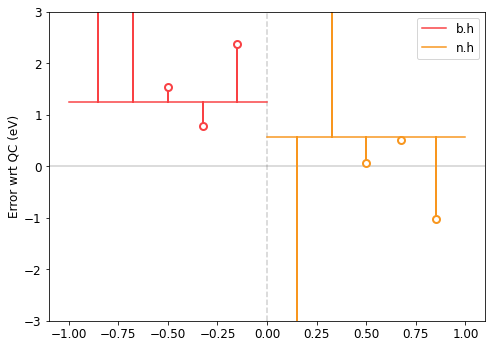

In [4]:
system_label = 'c.h'
system_charge = 0
excitation_level = 0
plot_apdft_orders = [0, 1, 2, 3, 4]
considered_lambdas = [-1, 1]

bl_eq_qc, e_eq_qc = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='qc',
    use_fin_diff=None, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

bl_eq_pred_alchemy, e_eq_pred_alchemy = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=False, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)
bl_eq_pred_apdft, e_eq_pred_apdft = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='alchemy',
    use_fin_diff=True, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

atomic_numbers_target = system_to_atomic_numbers(system_label)
atomic_numbers_refs = {key: system_to_atomic_numbers(key) for key in e_eq_pred_alchemy.keys()}
lambda_values_refs = {
    key: get_lambda_value(atomic_numbers_target, value, specific_atom=0) for key,value in atomic_numbers_refs.items()
}

e_ref = e_eq_qc[system_label]
e_eq_pred_alchemy_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_alchemy.items()}
e_eq_pred_apdft_error_qc = {key:hartree_to_ev(value-e_ref) for key,value in e_eq_pred_apdft.items()}

print('Alchemical error wrt QC')
print(pd.DataFrame(e_eq_pred_alchemy_error_qc))



###   FIGURE   ###
lolli_line_width = 2
yaxis_max = 3
marker_size = 7
edge_buffer = 0.15
colors = ['#F94144', '#F8961E', '#43AA8B', '#577590', '#F9C74F']

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.axhline(color='dimgrey', linestyle='-', alpha=0.3)
ax.axvline(color='dimgrey', linestyle='--', alpha=0.3)


i_color = 0
sys_keys_sorted = list(e_eq_pred_apdft_error_qc.keys())
sys_keys_sorted.sort()
for key in sys_keys_sorted:
    lambda_value = lambda_values_refs[key]
    alchemy_error_qc = e_eq_pred_alchemy_error_qc[key]
    apdft_error_qc = e_eq_pred_apdft_error_qc[key]
    color = colors[i_color]
    
    # Alchemical error line
    if lambda_value < 0:
        x_alchemical = [lambda_value, lambda_value+1]
    else:
        x_alchemical = [lambda_value-1, lambda_value]
    
    ax.plot(
        x_alchemical, [alchemy_error_qc, alchemy_error_qc],
        marker='', color=color, label=key
    )
    
    # APDFT error lollipop
    x_apdft = np.linspace(x_alchemical[0] + edge_buffer, x_alchemical[1] - edge_buffer, num=len(plot_apdft_orders))
    apdft_error_qc = apdft_error_qc[plot_apdft_orders]
    
    for i in range(len(plot_apdft_orders)):
        ax.plot(
            [x_apdft[i], x_apdft[i]], [alchemy_error_qc, apdft_error_qc[i]],
            marker='', markersize=0, 
            linestyle='-', linewidth=lolli_line_width,
            color=color
        )
        ax.plot(
            x_apdft[i], apdft_error_qc[i],
            marker='o', markersize=marker_size, markeredgewidth=lolli_line_width,
            linestyle='', linewidth=0,
            color=color, markerfacecolor='white'
        )
    
    i_color += 1

ax.set_ylabel('Error wrt QC (eV)')
ax.set_ylim((-yaxis_max, yaxis_max))

ax.legend()

print()